<a href="https://colab.research.google.com/github/ua-datalab/Workshops/blob/main/spark_workshop/Spark_Workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install pyspark==3.5.0

In [ ]:
%%capture
!pip install duckdb==0.8.0
!pip install duckdb-engine==0.8.0
!mkdir -p /db_file

In [ ]:
from pyspark.sql import SparkSession

# Initialize SparkSession
spark = SparkSession.builder \
  .config("spark.jars.packages", "org.duckdb:duckdb_jdbc:0.8.0") \
  .getOrCreate()

## Introduction

### What is Apache Spark?

Apache Spark is an open-source unified analytics engine for large-scale data processing of data engineering, data science, and machine learning on single-node machines or clusters.

### Why Spark?

- Problem:	Single machine can not complete the computaion
- Soluion: Parallelize the job and distribute	work among a network of machines

Databricks completed the Daytona GraySort, which is a distributed sort of 100 terabyte (TB) of on-disk data, in 23 minutes with 206 machines with 6,592 cores during this year's Sort Benchmark competition.Databricks pushed Spark further to also sort one petabyte (PB) of data on 190 machines in under four hours (234 minutes).

### Why Spark is fast?
- In-Memory Processing: Spark leverages in-memory computing to process data in RAM, which significantly accelerates processing speeds compared to traditional disk-based systems.
- Distributed Computing: Spark distributes data across a cluster of machines, allowing for parallel processing of tasks.

## Spark Architecture
![Image](https://raw.githubusercontent.com/pal0064/tutorials/master/images/arch.png)


- **Master-Slave Architecture**: Spark follows a master-slave architecture. The Master node manages the distribution of tasks, while Worker nodes execute those tasks.
- **Cluster Manager**: The cluster manager is responsible for managing resources across the cluster. It allocates tasks to worker nodes based on available resources. Spark can work with different cluster managers, including Apache Mesos, Hadoop YARN, and its standalone cluster manager.
- **Driver Program**: The driver program is responsible for coordinating the execution of tasks in a Spark application. It is the entry point for any Spark functionality. The driver sends tasks to the cluster's worker nodes and schedules computations.
- **Worker Node**: Worker nodes are the machines in the cluster that execute the tasks assigned to them by the driver. Each worker node has its own executor processes. These processes are responsible for running computations and storing data locally.
- **Executor**: An executor is a process that runs on each worker node and is responsible for executing tasks. Executors manage both the computation and storage resources for the tasks they execute.
- **Task**: A task is a unit of work that is sent to a worker node for execution. Tasks are created by the driver and executed by the executors.

## Components

![Image](https://raw.githubusercontent.com/pal0064/tutorials/master/images/components.png)

- **Spark Core** is the foundation of the platform. It is responsible for memory management, fault recovery, scheduling, distributing & monitoring jobs, and interacting with storage systems
- **Spark Streaming** is an extension of the core Spark API that enables scalable, high-throughput, fault-tolerant stream processing of live data streams.
- **Spark SQL** provides a unified data processing framework for both structured and unstructured data. It allows you to execute SQL queries alongside your Spark code.
- **MLlib** is Spark's machine learning library. It provides a wide range of algorithms and tools for building and training machine learning models at scale.
- **GraphX** is Apache Spark's API for graphs and graph-parallel computation.

### Spark APIs

1. **Resilient Distributed Dataset** (RDD): RDD is the fundamental data structure in Spark. It is an immutable distributed collection of objects that can be processed in parallel across a cluster.


![Image](https://raw.githubusercontent.com/pal0064/tutorials/master/images/rdd.png)

In [ ]:
import os
cwd = os.getcwd()
def get_path(file_name):
    return f'file://{cwd}/{file_name}'

In [ ]:
!wget https://raw.githubusercontent.com/apache/spark/master/examples/src/main/resources/people.txt
file_path = get_path('people.txt')
rdd = spark.sparkContext.textFile(file_path)
rdd

--2023-11-08 15:42:22--  https://raw.githubusercontent.com/apache/spark/master/examples/src/main/resources/people.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32 [text/plain]
Saving to: ‘people.txt’

people.txt          100%[===================>]      32  --.-KB/s    in 0s      

2023-11-08 15:42:23 (733 KB/s) - ‘people.txt’ saved [32/32]



file:///content/people.txt MapPartitionsRDD[1] at textFile at NativeMethodAccessorImpl.java:0

In [ ]:
rdd.collect()

['Michael, 29', 'Andy, 30', 'Justin, 19']

2. **DataFrame and Dataset API**: DataFrame and Dataset APIs provide a higher-level abstraction for working with structured data, allowing for more SQL-like operations and optimizations. The Dataset API is available in Scala and Java. Python does not have the support for the Dataset API

In [ ]:
df = spark.read.csv(file_path,header=False).toDF('Name', 'Age')
df # lazy evaluation

DataFrame[Name: string, Age: string]

In [ ]:
df.show()

+-------+---+
|   Name|Age|
+-------+---+
|Michael| 29|
|   Andy| 30|
| Justin| 19|
+-------+---+



### Spark job flow components

- **Directed Acyclic Graph (DAG)**: Spark transforms the operations on RDDs into a logical plan called a DAG. The DAG represents the flow of data and operations to be performed. It helps in optimizing the execution of tasks.
- **Job**: A job is submitted to Spark for execution in response to an action (e.g., collect, save). Jobs are broken down into stages.
- **Stage**: A stage is a unit of work that can be executed in parallel. A job may consist of multiple stages, and each stage corresponds to a set of tasks that can be executed without shuffling data across the network.

# Data Importing

In [ ]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
iris = load_iris(as_frame=True)
iris = iris.frame

### Converting a python dataframe to spark dataframe

In [ ]:
iris_spark_df = spark.createDataFrame(iris)
iris_spark_df.printSchema()

root
 |-- sepal length (cm): double (nullable = true)
 |-- sepal width (cm): double (nullable = true)
 |-- petal length (cm): double (nullable = true)
 |-- petal width (cm): double (nullable = true)
 |-- target: long (nullable = true)



### Read a csv file directly via spark

In [ ]:
%%capture
!wget https://gist.githubusercontent.com/netj/8836201/raw/6f9306ad21398ea43cba4f7d537619d0e07d5ae3/iris.csv
iris_csv_file_path = get_path('iris.csv')

In [ ]:
iris_spark_df = spark.read.csv(iris_csv_file_path, header=True,inferSchema=True)

### Writing json formatted files using spark

In [ ]:
iris_json_dir_path = get_path('iris_json')
iris_spark_df.write.json(iris_json_dir_path,mode='overwrite')

### Read a json file directly via spark

In [ ]:
df = spark.read.json(iris_json_dir_path)

In [ ]:
df.show()

+------------+-----------+------------+-----------+-------+
|petal.length|petal.width|sepal.length|sepal.width|variety|
+------------+-----------+------------+-----------+-------+
|         1.4|        0.2|         5.1|        3.5| Setosa|
|         1.4|        0.2|         4.9|        3.0| Setosa|
|         1.3|        0.2|         4.7|        3.2| Setosa|
|         1.5|        0.2|         4.6|        3.1| Setosa|
|         1.4|        0.2|         5.0|        3.6| Setosa|
|         1.7|        0.4|         5.4|        3.9| Setosa|
|         1.4|        0.3|         4.6|        3.4| Setosa|
|         1.5|        0.2|         5.0|        3.4| Setosa|
|         1.4|        0.2|         4.4|        2.9| Setosa|
|         1.5|        0.1|         4.9|        3.1| Setosa|
|         1.5|        0.2|         5.4|        3.7| Setosa|
|         1.6|        0.2|         4.8|        3.4| Setosa|
|         1.4|        0.1|         4.8|        3.0| Setosa|
|         1.1|        0.1|         4.3| 

In [ ]:
iris_spark_df.printSchema()

root
 |-- sepal.length: double (nullable = true)
 |-- sepal.width: double (nullable = true)
 |-- petal.length: double (nullable = true)
 |-- petal.width: double (nullable = true)
 |-- variety: string (nullable = true)



### Reading data from a database using spark

#### Creating a duckdb table using csv file

In [ ]:
import duckdb
con = duckdb.connect('/db_file/default_spark_workshop.db')
con.sql("""CREATE TABLE if not exists iris_data AS SELECT * FROM read_csv_auto('iris.csv')""")
con.sql(""" SELECT "sepal.length" FROM read_csv_auto('iris.csv')""").show()
con.close()

┌──────────────┐
│ sepal.length │
│    double    │
├──────────────┤
│          5.1 │
│          4.9 │
│          4.7 │
│          4.6 │
│          5.0 │
│          5.4 │
│          4.6 │
│          5.0 │
│          4.4 │
│          4.9 │
│           ·  │
│           ·  │
│           ·  │
│          6.7 │
│          6.9 │
│          5.8 │
│          6.8 │
│          6.7 │
│          6.7 │
│          6.3 │
│          6.5 │
│          6.2 │
│          5.9 │
├──────────────┤
│   150 rows   │
│  (20 shown)  │
└──────────────┘



#### Reading data from duckdb table using spark jdbc

In [ ]:
url="jdbc:duckdb:/db_file/default_spark_workshop.db"
table='iris_data'
properties = {'driver':'org.duckdb.DuckDBDriver',"duckdb.read_only": "true"
              }
spark.read.jdbc(url=url, table=table, properties=properties).show()

+------------+-----------+------------+-----------+-------+
|sepal.length|sepal.width|petal.length|petal.width|variety|
+------------+-----------+------------+-----------+-------+
|         5.1|        3.5|         1.4|        0.2| Setosa|
|         4.9|        3.0|         1.4|        0.2| Setosa|
|         4.7|        3.2|         1.3|        0.2| Setosa|
|         4.6|        3.1|         1.5|        0.2| Setosa|
|         5.0|        3.6|         1.4|        0.2| Setosa|
|         5.4|        3.9|         1.7|        0.4| Setosa|
|         4.6|        3.4|         1.4|        0.3| Setosa|
|         5.0|        3.4|         1.5|        0.2| Setosa|
|         4.4|        2.9|         1.4|        0.2| Setosa|
|         4.9|        3.1|         1.5|        0.1| Setosa|
|         5.4|        3.7|         1.5|        0.2| Setosa|
|         4.8|        3.4|         1.6|        0.2| Setosa|
|         4.8|        3.0|         1.4|        0.1| Setosa|
|         4.3|        3.0|         1.1| 

#### Reading data from duckdb table via sql query using spark jdbc

In [ ]:
spark.read.format("jdbc")\
.option("url", url)\
.option("query", """select min("sepal.length") as min_sepal_length,avg("sepal.length") as avg_sepal_length, max("sepal.length")as max_sepal_length from default_spark_workshop.iris_data""")\
.option('driver','org.duckdb.DuckDBDriver')\
.option('duckdb.read_only','true')\
.load().show()

+----------------+-----------------+----------------+
|min_sepal_length| avg_sepal_length|max_sepal_length|
+----------------+-----------------+----------------+
|             4.3|5.843333333333335|             7.9|
+----------------+-----------------+----------------+



#### Reading data from duckdb table by increasing the parallelism using spark jdbc

In [ ]:
df=spark.read.jdbc(url=url, table=table, properties=properties,predicates=['"sepal.length" between 4 and 5','"sepal.length" >5 and "sepal.length" <7','"sepal.length" >7 '])
df.rdd.getNumPartitions()

3

# Data Preprocessing and Transformation


### Renaming dataframe columns

In [ ]:
renamed_iris_spark_df=df.repartition(8)
for column in df.columns:
  renamed_iris_spark_df  = renamed_iris_spark_df.withColumnRenamed(column,column.replace('.','_'))
renamed_iris_spark_df.printSchema()

root
 |-- sepal_length: double (nullable = true)
 |-- sepal_width: double (nullable = true)
 |-- petal_length: double (nullable = true)
 |-- petal_width: double (nullable = true)
 |-- variety: string (nullable = true)



#### Creating a spark sql table from a dataframe

In [ ]:
renamed_iris_spark_df.registerTempTable("iris_table")

/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:329: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


In [ ]:
spark.sql("select min(sepal_length),max(sepal_length), min(sepal_width),max(sepal_width),min(petal_length),max(petal_length), min(petal_width),max(petal_width) from iris_table").show()

+-----------------+-----------------+----------------+----------------+-----------------+-----------------+----------------+----------------+
|min(sepal_length)|max(sepal_length)|min(sepal_width)|max(sepal_width)|min(petal_length)|max(petal_length)|min(petal_width)|max(petal_width)|
+-----------------+-----------------+----------------+----------------+-----------------+-----------------+----------------+----------------+
|              4.3|              7.9|             2.0|             4.4|              1.0|              6.9|             0.1|             2.5|
+-----------------+-----------------+----------------+----------------+-----------------+-----------------+----------------+----------------+



### Plotting a correlation matrix

#### Calculate correlation using spark

In [ ]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

string_columns = ['variety']
# Converting string columns to indexes so that correlation method can run
# A StringIndexer indexer that maps a string column of labels to an ML column of label indices
indexers = [StringIndexer(inputCol=column, outputCol= column+'_index').setHandleInvalid("skip").fit(renamed_iris_spark_df) for column in string_columns ]
# Creating a spark ML pipeline
# A Pipeline is specified as a sequence of stages, and each stage is either a Transformer or an Estimator.
# These stages are run in order, and the input DataFrame is transformed as it passes through each stage.
pipeline = Pipeline(stages=indexers)
transformed_df = pipeline.fit(renamed_iris_spark_df).transform(renamed_iris_spark_df)
df_r = transformed_df
t_df = df_r.drop(*string_columns)
t_df.printSchema()
vector_col = "corr_features"
#Creating a vector of features
assembler = VectorAssembler(inputCols= t_df.columns, outputCol=vector_col)  #A feature transformer that merges multiple columns into a vector column
df_vector = assembler.transform(t_df).select(vector_col)
# Creating correlation matrix from vector
matrix = Correlation.corr(df_vector, vector_col)

root
 |-- sepal_length: double (nullable = true)
 |-- sepal_width: double (nullable = true)
 |-- petal_length: double (nullable = true)
 |-- petal_width: double (nullable = true)
 |-- variety_index: double (nullable = false)



#### Plotting the matrix

<Axes: >

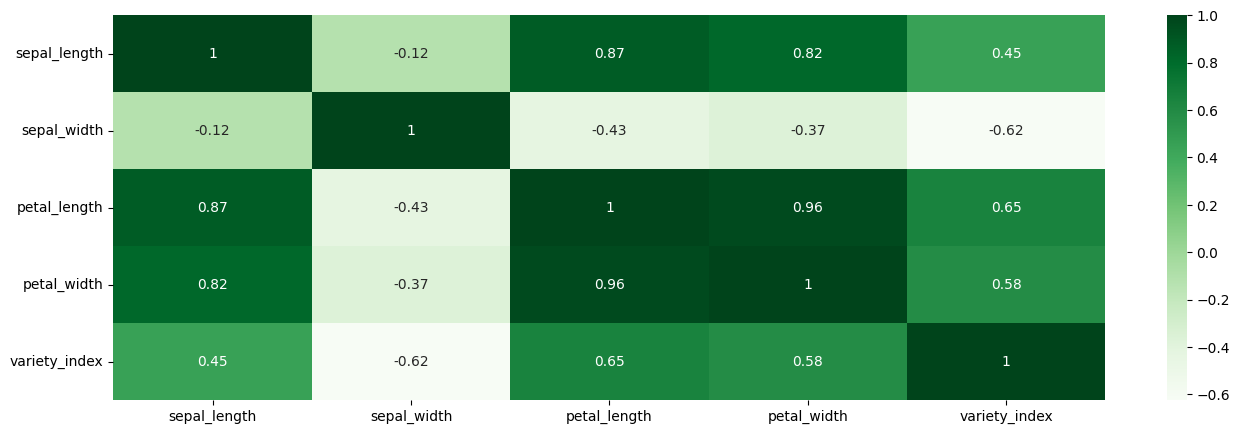

In [ ]:
import pandas as pd
corr_matrix = matrix.collect()[0][0].toArray().tolist()
corr_matrix_df = pd.DataFrame(data=corr_matrix, columns = t_df.columns, index=t_df.columns)
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(16,5))
sns.heatmap(corr_matrix_df,
            xticklabels=corr_matrix_df.columns.values,
            yticklabels=corr_matrix_df.columns.values,  cmap="Greens", annot=True)

In [ ]:
transformed_df.show()

+------------+-----------+------------+-----------+----------+-------------+
|sepal_length|sepal_width|petal_length|petal_width|   variety|variety_index|
+------------+-----------+------------+-----------+----------+-------------+
|         4.9|        3.6|         1.4|        0.1|    Setosa|          0.0|
|         4.4|        3.0|         1.3|        0.2|    Setosa|          0.0|
|         4.9|        3.0|         1.4|        0.2|    Setosa|          0.0|
|         5.0|        3.0|         1.6|        0.2|    Setosa|          0.0|
|         6.6|        2.9|         4.6|        1.3|Versicolor|          2.0|
|         5.4|        3.9|         1.7|        0.4|    Setosa|          0.0|
|         5.7|        2.8|         4.1|        1.3|Versicolor|          2.0|
|         5.5|        2.3|         4.0|        1.3|Versicolor|          2.0|
|         5.1|        2.5|         3.0|        1.1|Versicolor|          2.0|
|         5.6|        3.0|         4.5|        1.5|Versicolor|          2.0|

### Preparing feature vector for machine learning models

In [ ]:
featureassembler= VectorAssembler(inputCols=['sepal_length','sepal_width','petal_length','petal_width'], outputCol='Features')
features_df = featureassembler.transform(transformed_df)
features_df.show()

+------------+-----------+------------+-----------+----------+-------------+-----------------+
|sepal_length|sepal_width|petal_length|petal_width|   variety|variety_index|         Features|
+------------+-----------+------------+-----------+----------+-------------+-----------------+
|         4.9|        3.6|         1.4|        0.1|    Setosa|          0.0|[4.9,3.6,1.4,0.1]|
|         4.4|        3.0|         1.3|        0.2|    Setosa|          0.0|[4.4,3.0,1.3,0.2]|
|         4.9|        3.0|         1.4|        0.2|    Setosa|          0.0|[4.9,3.0,1.4,0.2]|
|         5.0|        3.0|         1.6|        0.2|    Setosa|          0.0|[5.0,3.0,1.6,0.2]|
|         6.6|        2.9|         4.6|        1.3|Versicolor|          2.0|[6.6,2.9,4.6,1.3]|
|         5.4|        3.9|         1.7|        0.4|    Setosa|          0.0|[5.4,3.9,1.7,0.4]|
|         5.7|        2.8|         4.1|        1.3|Versicolor|          2.0|[5.7,2.8,4.1,1.3]|
|         5.5|        2.3|         4.0|        1.3

#### Normalization of features using spark

In [ ]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="Features", outputCol="scaled_features", withStd=True, withMean=True)

scaler_model = scaler.fit(features_df)

# Normalize the features
scaled_df = scaler_model.transform(features_df)
scaled_df = scaled_df.drop(*['sepal_length','sepal_width','petal_length','petal_width','Features'])
scaled_df.show()

+----------+-------------+--------------------+
|   variety|variety_index|     scaled_features|
+----------+-------------+--------------------+
|    Setosa|          0.0|[-1.1335243042213...|
|    Setosa|          0.0|[-1.7393174223311...|
|    Setosa|          0.0|[-1.1335243042213...|
|    Setosa|          0.0|[-1.0123656805994...|
|Versicolor|          2.0|[0.92617229735162...|
|    Setosa|          0.0|[-0.5277311861116...|
|Versicolor|          2.0|[-0.1642553152458...|
|Versicolor|          2.0|[-0.4065725624897...|
|Versicolor|          2.0|[-0.8912070569775...|
|Versicolor|          2.0|[-0.2854139388677...|
| Virginica|          1.0|[1.04733092097357...|
| Virginica|          1.0|[0.56269642648580...|
| Virginica|          1.0|[0.56269642648580...|
| Virginica|          1.0|[0.56269642648580...|
| Virginica|          1.0|[0.56269642648580...|
| Virginica|          1.0|[1.04733092097357...|
|    Setosa|          0.0|[-0.5277311861116...|
| Virginica|          1.0|[1.65312403908

# Machine Learning with Spark

#### Splitting the dataset into train and test

In [ ]:
train_data,test_data=scaled_df.randomSplit([0.8,0.2],seed=42)

#### Running Random forest on training data

In [ ]:
rf = RandomForestClassifier(featuresCol='scaled_features', labelCol='variety_index',maxBins=2,seed=42)
rf=rf.fit(train_data)
y_pred = rf.transform(test_data)

### Evaluating the model performance

In [ ]:
evaluator = MulticlassClassificationEvaluator(
    labelCol='variety_index', predictionCol='prediction')
accuracy = evaluator.evaluate(y_pred)
accuracy

0.8444765111431778

#### Cross validation to find the best model using spark

In [ ]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
rf = RandomForestClassifier(featuresCol='scaled_features', labelCol='variety_index',seed=42)

pipeline = Pipeline(stages=[rf])

paramGrid = ParamGridBuilder()\
            .addGrid(rf.numTrees, [3,10])\
            .addGrid(rf.maxBins, [32,100])\
            .addGrid(rf.maxDepth, [5,10])\
            .addGrid(rf.impurity,['gini','entropy'])\
            .build()

evaluator = MulticlassClassificationEvaluator(
    labelCol="variety_index", predictionCol="prediction", metricName="accuracy")

crossval = CrossValidator(\
                          estimator=pipeline,\
                         estimatorParamMaps=paramGrid,\
                         evaluator=evaluator,\
                         numFolds=4)


model = crossval.fit(train_data)


predictions = model.transform(test_data)

evaluator2 = MulticlassClassificationEvaluator(
    labelCol="variety_index", predictionCol="prediction", metricName="f1")
accuracy = evaluator.evaluate(predictions)
f1 = evaluator2.evaluate(predictions)
print("accuracy = %g" % (accuracy))
print("f1 score = %g" % (f1))

bestPipeline = model.bestModel


accuracy = 0.939394
f1 score = 0.939394


In [ ]:
bestLRModel = bestPipeline.stages[0]
bestParams = bestLRModel.extractParamMap()
print("\n".join("{}\t{}".format(k, v) for k, v in bestParams.items()))

RandomForestClassifier_73845552af0d__bootstrap	True
RandomForestClassifier_73845552af0d__cacheNodeIds	False
RandomForestClassifier_73845552af0d__checkpointInterval	10
RandomForestClassifier_73845552af0d__featureSubsetStrategy	auto
RandomForestClassifier_73845552af0d__featuresCol	scaled_features
RandomForestClassifier_73845552af0d__impurity	entropy
RandomForestClassifier_73845552af0d__labelCol	variety_index
RandomForestClassifier_73845552af0d__leafCol	
RandomForestClassifier_73845552af0d__maxBins	32
RandomForestClassifier_73845552af0d__maxDepth	10
RandomForestClassifier_73845552af0d__maxMemoryInMB	256
RandomForestClassifier_73845552af0d__minInfoGain	0.0
RandomForestClassifier_73845552af0d__minInstancesPerNode	1
RandomForestClassifier_73845552af0d__minWeightFractionPerNode	0.0
RandomForestClassifier_73845552af0d__numTrees	10
RandomForestClassifier_73845552af0d__predictionCol	prediction
RandomForestClassifier_73845552af0d__probabilityCol	probability
RandomForestClassifier_73845552af0d__ra

In [ ]:
print(bestLRModel.toDebugString)

RandomForestClassificationModel: uid=RandomForestClassifier_73845552af0d, numTrees=10, numClasses=3, numFeatures=4
  Tree 0 (weight 1.0):
    If (feature 2 <= -0.7073435185764505)
     Predict: 0.0
    Else (feature 2 > -0.7073435185764505)
     If (feature 2 <= 0.5641680878726377)
      Predict: 2.0
     Else (feature 2 > 0.5641680878726377)
      If (feature 3 <= 0.7219359351966296)
       If (feature 2 <= 0.7902145956858089)
        Predict: 2.0
       Else (feature 2 > 0.7902145956858089)
        Predict: 1.0
      Else (feature 3 > 0.7219359351966296)
       Predict: 1.0
  Tree 1 (weight 1.0):
    If (feature 3 <= -0.8474518485499649)
     Predict: 0.0
    Else (feature 3 > -0.8474518485499649)
     If (feature 3 <= 0.5911536198844134)
      If (feature 2 <= 0.7902145956858089)
       Predict: 2.0
      Else (feature 2 > 0.7902145956858089)
       Predict: 1.0
     Else (feature 3 > 0.5911536198844134)
      Predict: 1.0
  Tree 2 (weight 1.0):
    If (feature 3 <= -0.5204960602694